In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

If you were trying to train a neural network back in 2014, you would have definitely observed the so-called vanishing gradient problem. 

# The update rule and the vanishing gradient problem

The vanishing gradient problem is a challenge in deep learning where gradients become extremely small during backpropagation, preventing earlier layers in a neural network from learning effectively. This happens because the gradients are repeatedly multiplied by small numbers (often from activation functions like sigmoid) as they move from the output layer back to the input layer, causing their magnitude to shrink exponentially. This leads to weights in the initial layers updating very slowly or not at all, which slows down or halts the training process.  

Simply stacking more layers can lead to higher training error because the network struggles to learn an effective identity mapping (i.e., learning to simply pass the input through without modification, H(x)≈x).

# Skip connections for the win

By using a skip connection, we provide an alternative path for the gradient.

> Skip connections, as the name suggests, skip some layer in the neural network and feed the output of one layer as the input to the next layers, instead of just the next one.

In general, there are two fundamental ways that one could use skip connections through different non-sequential layers:

a) Addition, as in residual architectures

b) Concatenation, as in densely connected architectures

# ResNet: skip connections via addition

Apart from the vanishing gradients, there is another reason for commonly using skip connections. For a plethora of tasks (such as semantic segmentation, optical flow estimation, etc.), some information was captured in the initial layers. We would like to allow the later layers to also learn from them.

It has been observed that in earlier layers, the learned features correspond to lower semantic information that is extracted from the input. If we had not used the skip connection, that information would have turned too abstract.

This is ResNet: the Residual Block (or identity block), which uses the skip connection (or identity mapping).

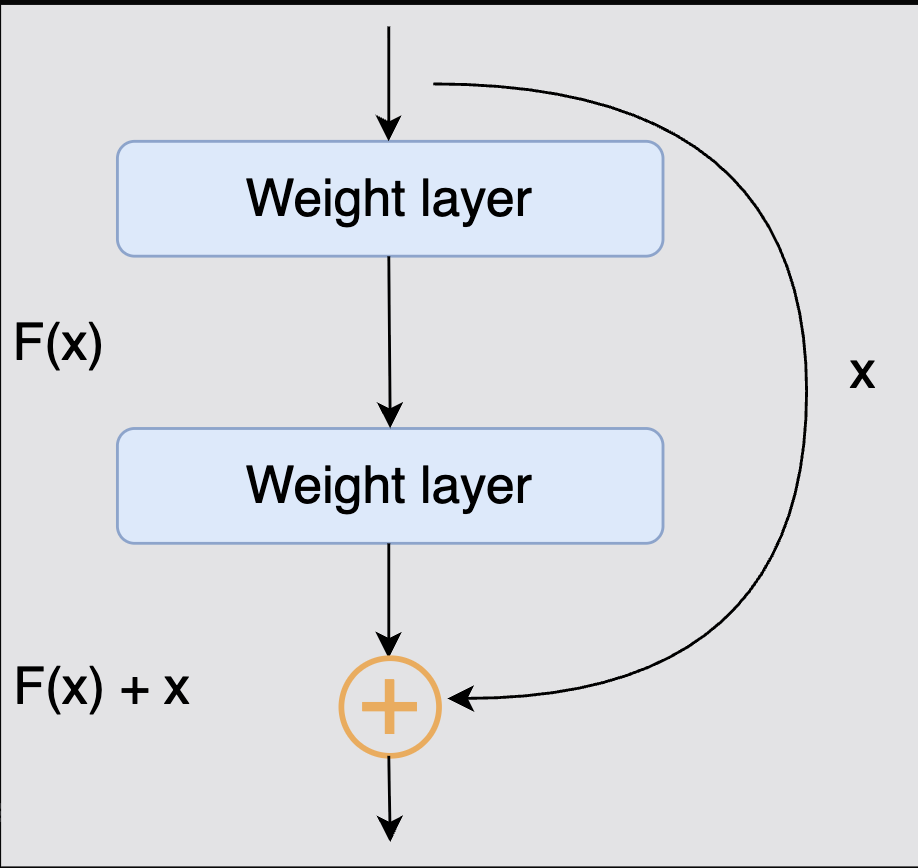

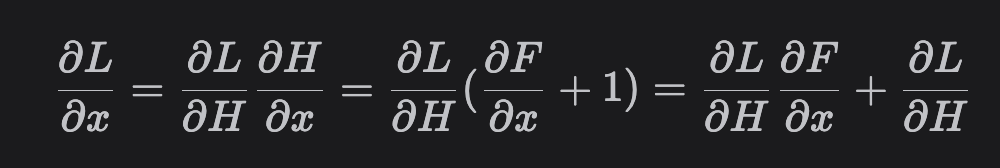

Yes, the purpose of the skip connection is precisely to allow the input to easily bypass one or more layers and pass its information to layers further down the network.

# The Residual Function
The skip connection solves the degradation problem by reframing the learning objective:

1. The Goal: Learn a Residual
- Instead of trying to learn a complex mapping H(x), the block is trained to learn the residual mapping, F(x), where F(x) is the difference between the desired output and the input:
  
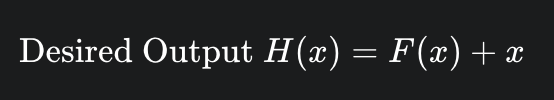

- Desired Output H(x)=F(x)+x
The entire block learns F(x), and the skip connection provides the +x part.

2. The Benefit of Learning F(x)
- Easy Identity: If the optimal transformation H(x) for the block is simply the identity function (H(x)=x), the network only needs to learn the trivial function F(x)=0. It's much easier for gradient descent to push the weights towards zero than it is to push the complex stacked layers to learn H(x)=x.

- Gradient Flow: The straight path provided by the skip connection acts like a direct data highway. During backpropagation, the gradient signal can flow unhindered through the addition operation, mitigating the vanishing gradient problem and allowing deep networks to train effectively.

The ResNet block shown contains two weight layers to allow the residual function, F(x), to be non-linear and more meaningful than just a simple scalar operation.

> The two layers provide the power and complexity needed to learn highly sophisticated residual functions F(x) when necessary, while the skip connection provides the simplicity and stability to learn F(x)=0 when necessary. The network gets the best of both worlds.

The primary goal of any layer in a neural network is not just to pass the input through, but to learn a better, more useful feature representation of that input.

If the input x is already a very good feature, the optimal result might indeed be F(x)≈0. The skip connection ensures the network can do this easily.

But if the input x is noisy, redundant, or incomplete, the block needs to learn a complex F(x) to extract new, deeper information or clean up the noise.

By giving the F(x) path two weight layers (and non-linearities), you ensure the block has the representational power to learn intricate transformations like:

- Noise Suppression: F(x) learns to negate noise present in x.

- Feature Augmentation: F(x) learns a new feature that, when added to x, creates a much more descriptive feature.

In [2]:
seed = 172
torch.manual_seed(seed)


class SkipConnection(nn.Module):

    def __init__(self):
        super(SkipConnection, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 2, stride=2, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.conv_layer2 = nn.Conv2d(6, 3, 2, stride=2, padding=2)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, input: torch.FloatTensor) -> torch.FloatTensor:
        x = self.conv_layer1(input)
        x = self.relu(x)
        x = self.conv_layer2(x)
        x = self.relu2(x)
        return x + input
        

# DenseNet: skip connections via concatenation

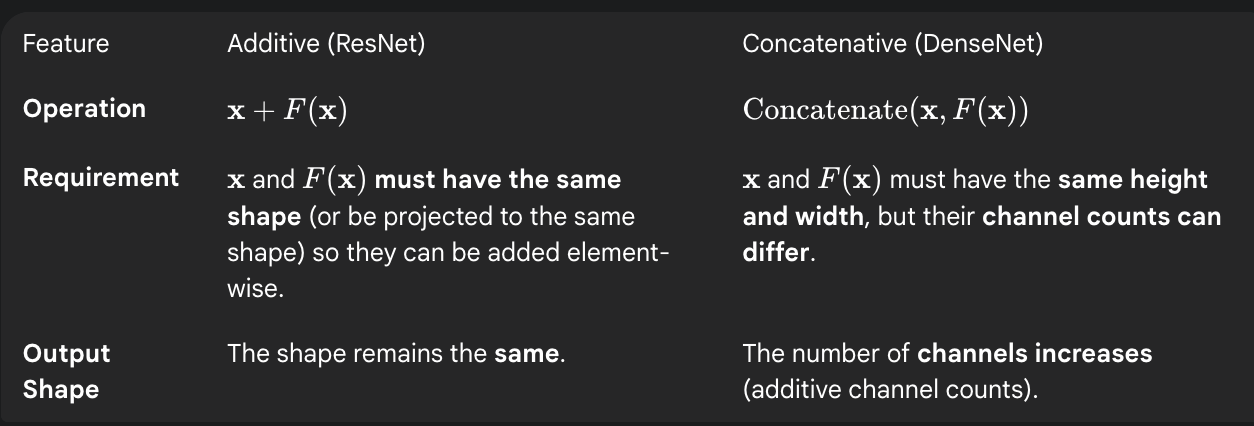

The main advantage of concatenation is extreme feature re-use:

Preservation: The original input features (x) are explicitly preserved and handed directly to the next layer, without being mixed, scaled, or corrupted by the layers within the block. The deeper layers can access high-resolution, early-stage features directly.

Gradient Flow: The straight concatenation path ensures an uninterrupted gradient flow backward. Since the gradient flows through the concatenation operator, it easily reaches the initial layers, further mitigating the vanishing gradient problem.

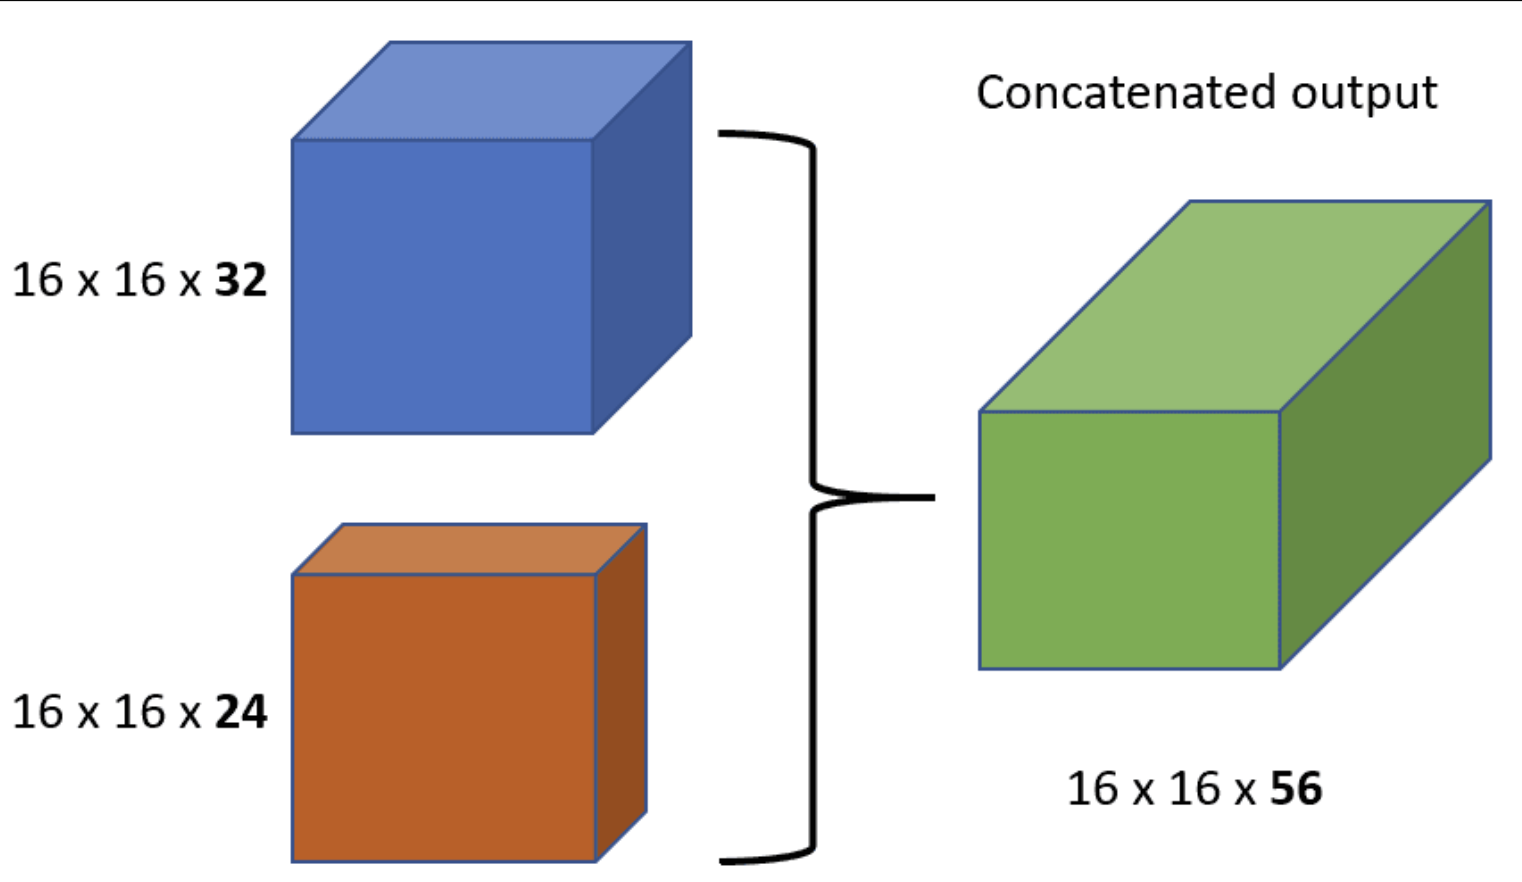

But takes a lot of memory!